In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, mpld3, glob, os
import pandas as pd, seaborn as sn, numpy as np
sn.set_context('talk')

In [13]:
# Hack to force Python 2 to recognise utf-8 encodings. See here:
# http://jonathansoma.com/tutorials/international-data/python-and-utf-8/
# Note that using this breaks subsequent print statements in the 
# notebook, which is annoying!
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

# Krypsiv regression relationships

Rather than looking for differences between nuisance and non-nuisance sites, Therese would like to explore the relationships between chemical parameters and indices of krypsiv growth (see e-mail received 17/11/2016 at 09:00). We have measurements for the total cover of krypsiv (as a percentage) at each site and also estimates for the total krypsiv volume (in unspecified units). I've added these measurements to `chem.xlsx` and the relationships are explored below.

## 1. Read data

At most of the sites we have data for three years, but the krypsiv measurements over time are unlikely to be statistically independent, because the percentage cover or volume of krypsiv in one year will be releated to the growth in other periods. This dependence could bias the regression results. 

One way to tackle this problem is to only consider the data from 2016 (or any other year), but this ignores the variability between years, which is substantial. An alternative is to calculate averages of water chemistry and krypsiv growth at each site. This approach has the advantage of using all of the data to some extent and may also "smooth out" outliers from individual years. The downside is that the resultant "blurring" may obscure relationships that would otherwise be visible in the data for a single year.

The code below can be easily adapted to switch between various options. I've tried just looking at the 2016 data and also considering the averaged values over all years. Both give more-or-less the same results. **The plots shown below use averages based on the full dataset (i.e. all years)**.

In [15]:
# Read data
in_xlsx = r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data\Tidied\chem.xlsx'
df = pd.read_excel(in_xlsx, sheetname='data')

# Adjust the code below to select which data to use
# Option 1: Averages over all years at each site
grpd = df.groupby(['Kortnavn', 'Name', 'Status'])
df = grpd.agg('mean')
df.reset_index(inplace=True)

# Option 2: Just the data for one year
#df = df.query('Year == 2016')

df.head()

,Kortnavn,Name,Status,ID,Year,Total cover,Total volume,Vann cond. (µS/cm),Vann temp. (C),Vann pH,...,CO2 (mg C/l),PO4 (µg P/l),NO3+NO2 (µg N/l),TOC (mg C/l),TotP (µg P/l),PW NH4 (µg N/l),PW CO2 (mg C/l),PW Fe (mg/l),PW NO3+NO2 (µg N/l),PW TotP (µg P/l)
0,BJO,BJO,Referanse,17.0,2015.0,2.500000,25.388889,18.000000,19.100000,6.55,...,1.618611,0.916667,59.666667,4.944444,4.888889,408.333333,6.040000,4.540000,198.666667,10.333333
1,BRO,BRO,Problemvekst,8.0,2015.0,86.333333,3436.444444,9.933333,10.566667,6.10,...,0.588333,1.000000,52.055556,1.422222,19.194444,15.333333,11.700000,3.565867,111.000000,8.666667
2,DRA,DRA,Problemvekst,18.0,2015.0,93.333333,2763.333333,21.366667,20.166667,6.55,...,1.146111,1.805556,83.166667,4.911111,8.388889,383.666667,19.800000,23.920000,35.666667,12.333333
3,FYG,FYG,Problemvekst,5.0,2015.0,54.166667,1435.361111,14.933333,15.733333,6.40,...,0.567500,0.888889,83.361111,3.722222,45.305556,16.666667,5.226667,0.863533,75.666667,8.000000
4,HER,HER,Problemvekst,15.0,2015.0,50.166667,1000.555556,16.000000,19.933333,6.95,...,0.771389,0.833333,36.125000,4.444444,3.638889,15.666667,8.985000,0.124800,257.666667,6.000000


## 2. Do nuisance sites have more krypsiv?

Before getting into regression relationships, the first thing to test is whether the nuisance sites actually have measurably more krypsiv than the non-nuisance sites.

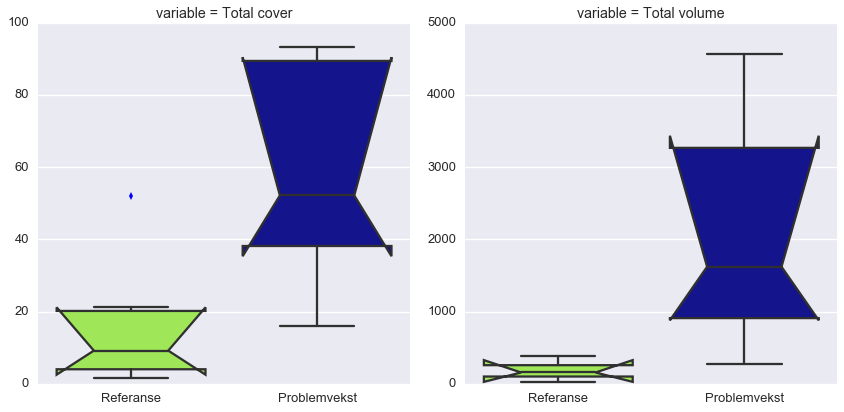

In [16]:
# Get just data of interest
df2 = df[['Status', 'Total cover', 'Total volume']]
df2 = pd.melt(df2, id_vars='Status')
df2

# Plot
g = sn.factorplot(x='Status', y='value',
                  col='variable', col_wrap=2,
                  data=df2, 
                  kind='box',
                  order=['Referanse', 'Problemvekst'],
                  notch=True,
                  bootstrap=1000,
                  sharex=False,
                  sharey=False,
                  palette={'Referanse':'#9FFF40',
                           'Problemvekst':'#0000A0'},
                  size=6)

g.set(ylabel='')
g.set(xlabel='')
plt.tight_layout()

# Save
out_fold = r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Plots'
out_path = os.path.join(out_fold, 'cover_volume_by_type.png')
plt.savefig(out_path, dpi=300)

This is good to see - the problem sites clearly have both a greater coverage of krypsiv and a greater volume of plant material.

## 3. Scatterplots

The next step is to look at the relationships between these two response variables (percentage cover and volume) and the various chemical parameters.

In [17]:
# Reshape df
df_long = pd.melt(df, id_vars=['Kortnavn', 'Name', 'ID', 'Year', 
                               'Status', 'Total cover', 'Total volume'])
df_long.head()

,Kortnavn,Name,ID,Year,Status,Total cover,Total volume,variable,value
0,BJO,BJO,17.0,2015.0,Referanse,2.500000,25.388889,Vann cond. (µS/cm),18.000000
1,BRO,BRO,8.0,2015.0,Problemvekst,86.333333,3436.444444,Vann cond. (µS/cm),9.933333
2,DRA,DRA,18.0,2015.0,Problemvekst,93.333333,2763.333333,Vann cond. (µS/cm),21.366667
3,FYG,FYG,5.0,2015.0,Problemvekst,54.166667,1435.361111,Vann cond. (µS/cm),14.933333
4,HER,HER,15.0,2015.0,Problemvekst,50.166667,1000.555556,Vann cond. (µS/cm),16.000000


### 3.1. Percentage cover

The scatterplots below are for percentage cover. I've added the best-fit line estimated using simple OLS regression in each case (with the 95% confidence interval shaded in blue). These regression lines should be interpreted with caution, as I haven't checked the redisuals etc., but main aim here is to try to identify possible relationships for further modelling.

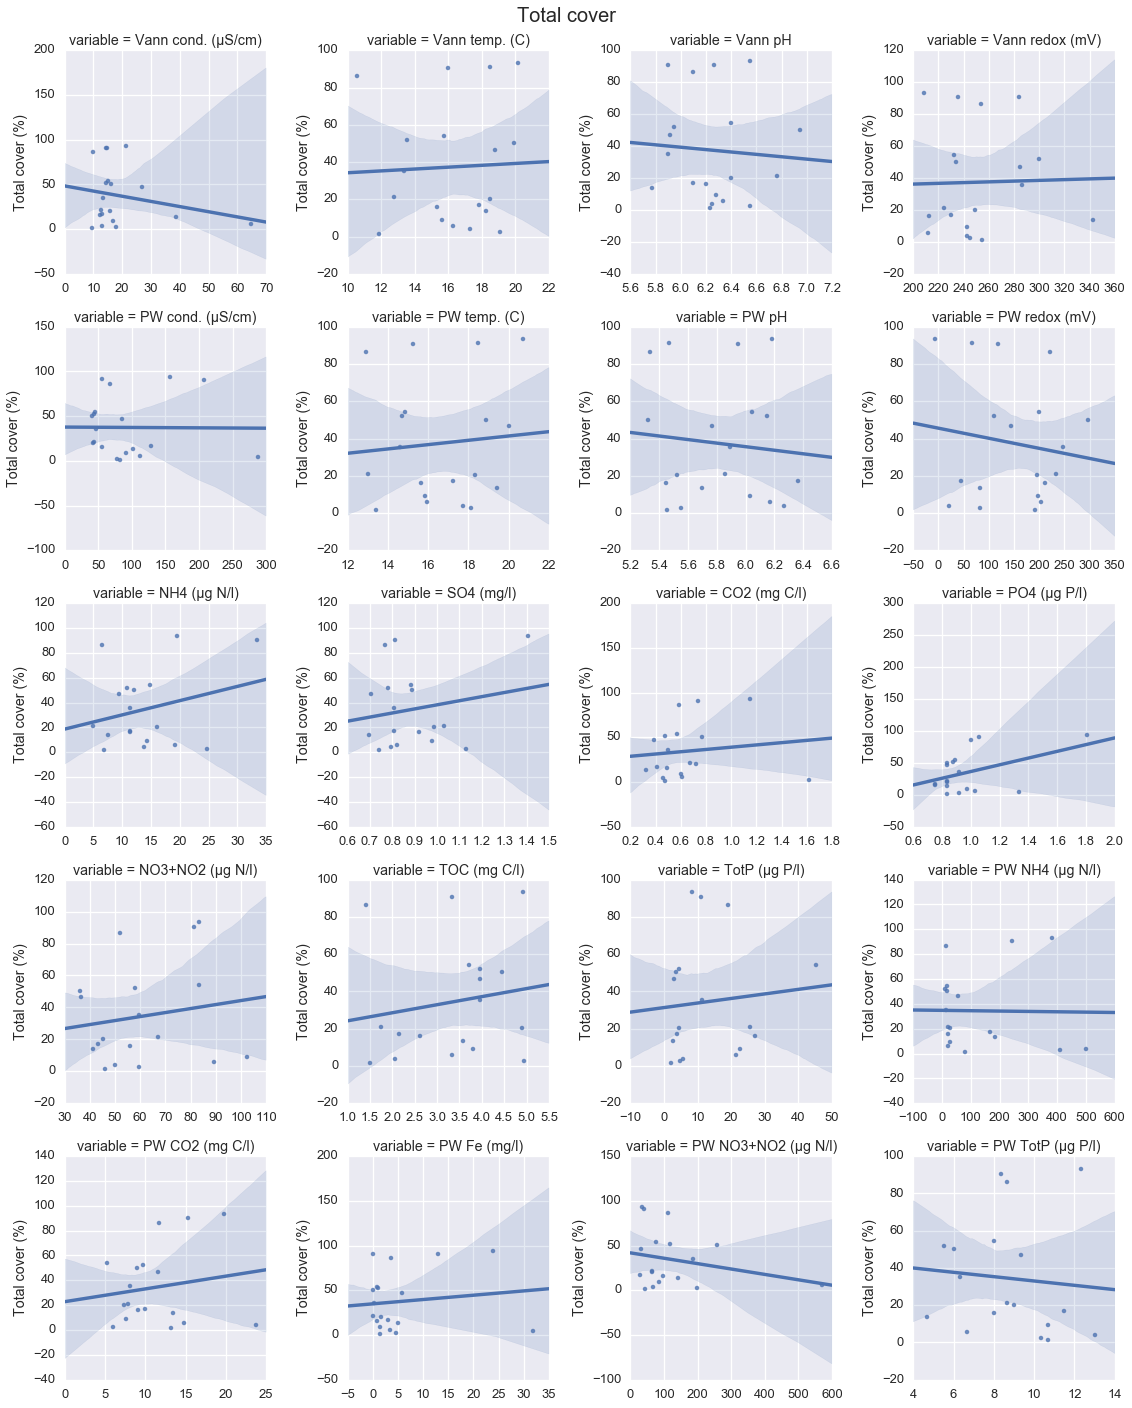

In [18]:
g = sn.FacetGrid(df_long, col="variable", 
                 col_wrap=4,
                 sharex=False, 
                 sharey=False, 
                 size=4)

g.map(sn.regplot, 'value', 'Total cover',
      fit_reg=True, ci=95)

g.set(ylabel='Total cover (%)')
g.set(xlabel='')
plt.suptitle('Total cover', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

### 3.2. Volume

The scatterplots below show krypsiv volume.

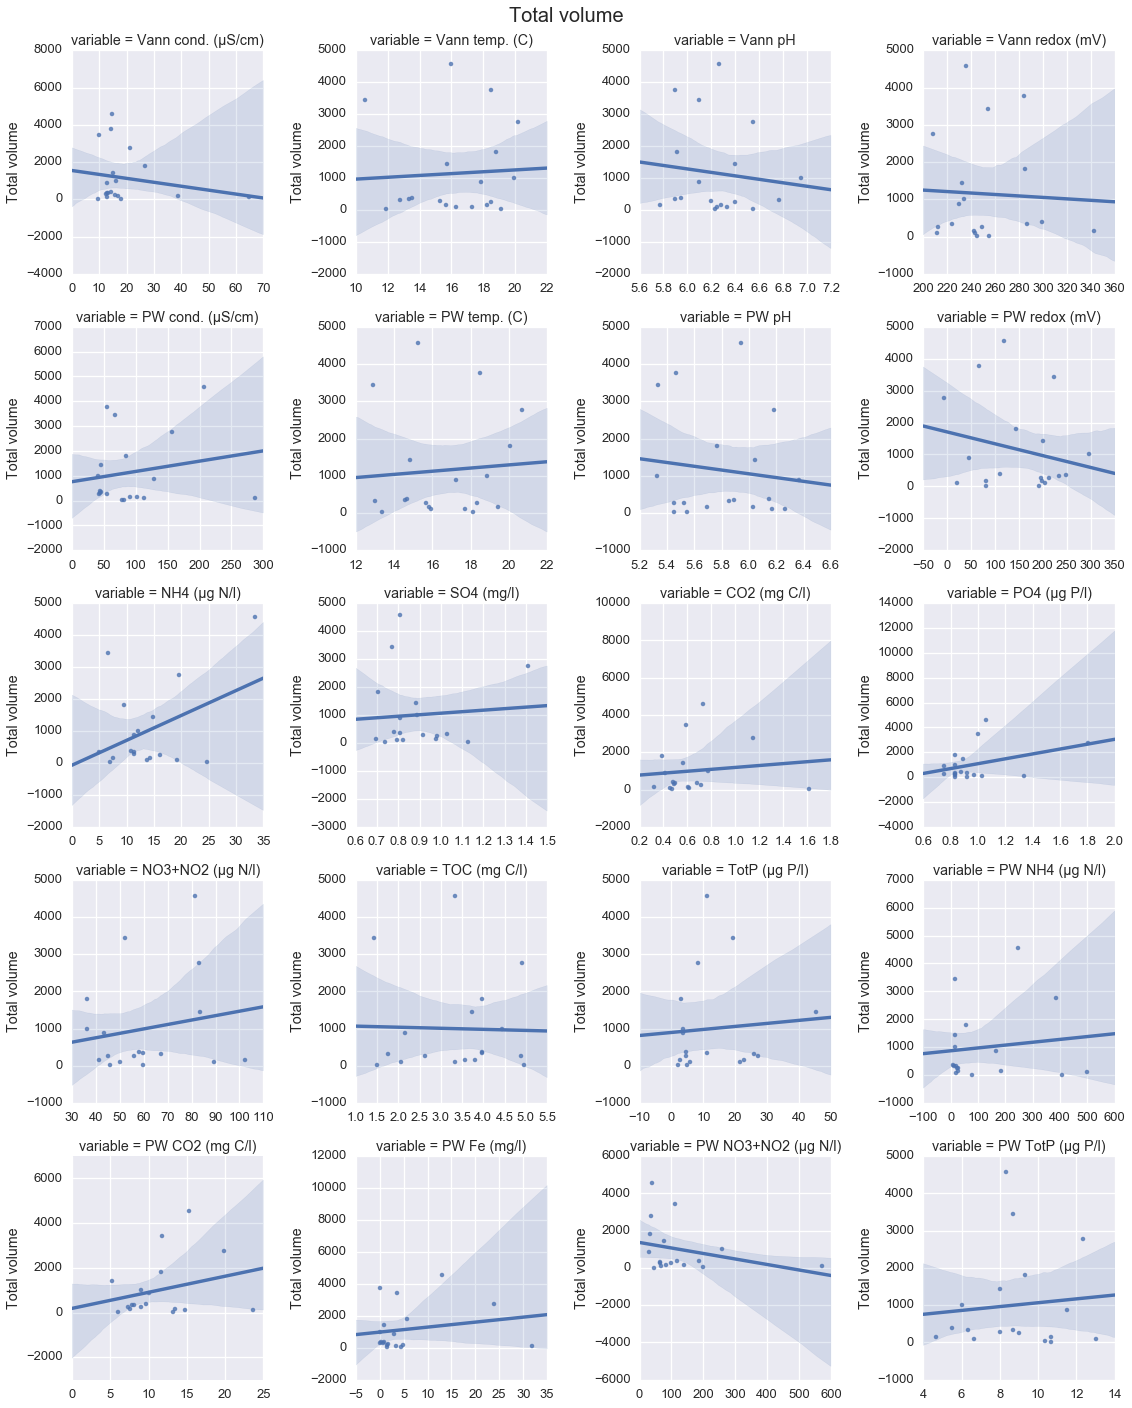

In [19]:
g = sn.FacetGrid(df_long, col="variable", 
                 col_wrap=4,
                 sharex=False, 
                 sharey=False, 
                 size=4)

g.map(sn.regplot, 'value', 'Total volume',
      fit_reg=True, ci=95)

g.set(ylabel='Total volume')
g.set(xlabel='')
plt.suptitle('Total volume', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

There are no clear relationships here. In fact, none of the regression lines are statistically significant at the 95% confidence level (i.e. the shaded 95% confidence window includes the horizontal "no effect" line in every case). What's more, there is no real evidence for any non-linear relationships either.

Therese's original e-mail suggested statistical modelling using [GLMs](https://en.wikipedia.org/wiki/Generalized_linear_model), which provide a more flexible alternative to linear regression because they can handle non-linear relationships and a wider variety of variable distributions. This is a good idea, but unfortunately, given the lack of any clear linear or non-linear relationships in the scatterplots above, I very much doubt GLMs will produce anything meaningful at this stage.

After speaking with Therese on the phone, she's also interested in [stepwise regression](https://en.wikipedia.org/wiki/Stepwise_regression), which tries to identify the best possible combination of predictors by iteratively testing and modifying a range of different model structures. However, stepwise regression has been heavily criticised by the statistical community and should generally be avoided except in special cases. [This paper](http://www.lexjansen.com/pnwsug/2008/DavidCassell-StoppingStepwise.pdf) and [this post by Andrew Gelman](http://andrewgelman.com/2014/06/02/hate-stepwise-regression/) highlight some of the main issues.

Rather than using stepwise approaches, some kind of **penalised/regularised regression** (e.g. Ridge, Lasso or Elastic Net) is often more appropriate. The notes and code below are duplicated from one of my [previous notebooks](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis2.ipynb), which explored Susi Schneider's ECOREG dataset.

## 4. Penalised regression

### 4.1. Background

#### 4.1.1. Norms

A "norm" is a method for calculating the length of a vector in a vector space (or the distance between two vectors). Because they are lengths, norms must be positive, and there are many different kinds. Although seemingly abstract, norms are closely related to fundamental statistical quantities, such as the [mean, median and mode](http://www.johnmyleswhite.com/notebook/2013/03/22/modes-medians-and-means-an-unifying-perspective/). Also, because norms express distance, they can be related to goodness-of-fit in statistical models: we're interested in the "distance" between our model predictions and the observations, when expressed in some suitable vector space.

It is common to talk about $L_p$ norms, where the distance between a point (vector) $x$ and the origin is given by

$$\lVert x \rVert_p = \left(\sum_i \lvert x_i \rvert^p \right)^{(1/p)}$$

where $\lVert x \rVert_p$ is the $L_p$ norm of $x$ and $p$ is a real number. 

The $L_2$ norm ($p=2$), also known as the **Euclidean distance**, is perhaps the most common. This is the *square root of the sum of squared differences* (where the differences here are between the point and the origin)

$$\lVert x \rVert_2 = \sqrt {\left(\sum_i \lvert x_i \rvert^2 \right)}$$

OLS regression attempts to minimse the *square* of the $L_2$ norm between model predictions and observations. The objective function for OLS can therefore be written

$$min \lVert Xw - y \rVert_2^2$$

where $X$ is the matrix of explanatory variables, $w$ is a vector of parameters and $y$ is a vector of observations. In other words, OLS regression minimises the sum of squared differences.

Another common norm is the $L_1$ norm, often known as the **Manhatten distance**

$$\lVert x_i \rVert_1 = \sum_i \lvert x_i \rvert$$

The $L_1$ norm is the sum of absolute distances or, if we're thinking about differences between two data vectors, the sum of absolute errors.

In two dimensions, the difference between $L_1$ and $L_2$ norms can be illustrated as shown below:

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/norms.png?raw=true" alt="norms" width="500">

The length of vector $a = (4, 3)$ using the $L_1$ norm is $(4 + 3) = 7$, whereas using the $L_2$ norm it's $\sqrt {(4^2 + 3^2)} = 5$. The $L_1$ norm is called the "Manhatten distance" because Manhatten streets are laid out on a grid, so the $L_1$ norm gives the driving distance between locations, whereas the $L_2$ norm gives the distance "as the crow flies".

#### 4.1.2. Norms and regression

With large numbers of collinear explanatory variables, multiple linear regression using OLS becomes problematic, because parameter interactions mean many possible parameter combinations give an equally good fit to the data. In two dimensions, this can be [visualised as a "ridge"](http://stats.stackexchange.com/questions/118712/why-does-ridge-estimate-become-better-than-ols-by-adding-a-constant-to-the-diago/120073#120073) in the likelihood function over the parameter space or, equally, as a "trough" in the OLS cost function. Such models are often characterised by large parameter values, which interact with one another and cancel out. In most cases, we would like to construct a **parsimonious model**, and one way to achieve this is to modify the OLS cost function to penalise models with lots of parameters and/or very large coefficients. This can be done in a number of ways, but some common options are:

 1. **Ridge regression ($L_2$ regularisation)**. The usual OLS cost function is modifed by adding-in the $L_2$ norm of the vector of model parameters ($w$)
 
 $$min \left( \lVert Xw - y \rVert_2^2 + \alpha \lVert w \rVert_2^2 \right)$$
 
 This equation depends sensitively on the size of the parameter estimates, with parameter values closer to zero being more   likely than those further away. The overall effect is to "bend" the ends of the ridge in the likelihood surface downwards, creating a maximum where previously one did not exist. This introduces a degree of bias into the model, but often results in better out-of-sample predictive performance. $L_2$ regularisation is also particularly well-suited to cases where collinearity is expected to be a problem, or where there are more explanatory variables than data points (see e.g. [here](http://stats.stackexchange.com/questions/184019/when-will-l1-regularization-work-better-than-l2-and-vice-versa)). <br><br>
 
 2. **Lasso regression ($L_1$ regularisation)**. Ridge regression forces parameter values to be small but, because of the dependence on the *square* of the parameter values, when parameters are close to zero their effect on the likelihood surface becomes very small. For this reason, ridge regression tends to favour models with small parameter values, but it rarely actually assigns zero to any of the model coefficients i.e. ridge regression will rarely decide that a particular explanatory variable is not important and remove it from the model. 
 
 Lasso regression is a related alternative that uses the $L_1$ norm
 
  $$min \left( \frac{1}{2n} \lVert Xw - y \rVert_2^2 + \alpha \lVert w \rVert_1 \right)$$
  
  This has a similar effect (i.e. favours simpler models), but the $L_1$ penalty frequently results in assigning parameter values of zero (i.e. choosing whether a particular variable should be included or not). Lasso regression therefore tends to produce **sparse models** with as few explanatory variables as possible, and it can therefore be viewed as incorporating a form of **feature selection**.
  
  **NB:** in both cases listed above, the $\alpha$ parameter controls the degree to which model complexity is penalised. There is no simple way to set this value - it must be tuned (calibrated) using cross-validation. <br><br>
  
 3. **Elastic net regression (combines $L_1$ and $L_2$ regularisation)**. Elastic net regression modifies the OLS cost function with a combination of the $L_1$ and $L_2$ penalties. See [here](http://scikit-learn.org/stable/modules/linear_model.html#elastic-net) for an explanation of the cost function. This method provides a very flexible approach to penalised regression, where the $L_2$ (Ridge) and $L_1$ (Lasso) cases are included as end members. 

### 4.2. Regularized Multiple Linear Regression (MLR)

The function below implements four different types of MLR (OLS, Ridge, Lasso and Elastic Net) and plots the results.

In [4]:
def mlr(df, exp_vars, resp_var, 
        method='ols', 
        fit_intercept=True,
        kcv=3,
        normalize=False):
    """ Performs various types of multiple linear regression.
    
    Args:
        df:            Data frame with features/responses as columns 
                       and samples as rows.
        exp_vars:      List of string specifying explanatory variables.
        resp_var:      String specifying the response variable.
        method:        'ols', 'lasso', 'ridge', 'el-net'.
        fit_intercept: Whether to fit an intercept. Default is True.
        kcv:           Number of "folds" for k-fold cross validation.
                       Default is 3.
        normalize:     Whether to normalise X before regression.
                       Default is False.
    Returns:
        A data frame of parameter estimates with (rather dodgy?)
        2-sigma error bounds and 95% significance
    """
    from sklearn import cross_validation
    from sklearn.linear_model import LinearRegression, RidgeCV
    from sklearn.linear_model import LassoCV, ElasticNetCV
    from sklearn.metrics import r2_score
    from sklearn.utils import resample 
    
    # Separate data
    X = df[exp_vars]
    y = df[resp_var]
    
    # Setup model
    if method == 'ols':
        model = LinearRegression(fit_intercept=fit_intercept, normalize=normalize)
    elif method == 'lasso':
        model = LassoCV(fit_intercept=fit_intercept, normalize=normalize, max_iter=10000)
    elif method == 'ridge':
        model = RidgeCV(fit_intercept=fit_intercept, normalize=normalize, 
                        alphas=np.logspace(-10, 10, 21))
    elif method == 'el-net':
        model = ElasticNetCV(fit_intercept=fit_intercept, normalize=normalize)
    else:
        raise ValueError('"method" parameter must be in ["ols", "lasso", "ridge", "el-net"]')
    
    # k-fold cross validation
    cv_scores = cross_validation.cross_val_score(model, X, y, cv=kcv, scoring='r2')
    print 'Mean r2 from %s-fold CV: %.3f\n' % (kcv, cv_scores.mean())
    
    # Train model on full dataset
    model.fit(X, y)
    
    # Get y-hat
    y_pred = model.predict(X)
    
    # r2 based on calibration data
    r2 = r2_score(y, y_pred)
    print 'r2 (based on the calibration data i.e. meaningless!):', r2
    print ''
    
    # Summary of model
    print model
    print ''
    
    if method == 'lasso':
        print 'Lasso alpha:', model.alpha_
        print ''
    elif method == 'ridge':
        print 'Ridge alpha:', model.alpha_
        print ''
    elif method == 'el-net':
        print 'Elastic net alpha:', model.alpha_   
        print 'Elastic net L1 ratio:', model.l1_ratio_ 
        print ''
    else: # OLS
        pass
    
    # Plot
    fig = plt.figure(figsize=(15,15))
    
    # Paired points for each site
    ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
    ax1.plot(range(0, len(X.index)), y, 'ro', label='Observed')
    ax1.plot(range(0, len(X.index)), y_pred, 'b^', label='Modelled')
    
    ax1.set_xticks(range(0, len(X.index)))
    ax1.set_xticklabels(X.index, rotation=90, fontsize=12)
    ax1.set_xlim(0, len(X.index)-1)
    
    ax1.set_xlabel('Site code', fontsize=16)
    ax1.set_ylabel(resp_var)
    ax1.set_title('Points paired for each location', fontsize=20)
    ax1.legend(loc='best', fontsize=16)
    
    # Modelled versus observed
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
    ax2.plot(y, y_pred, 'ro')
    ax2.set_xlabel('Observed', fontsize=16)
    ax2.set_ylabel('Modelled', fontsize=16)
    ax2.set_title('Modelled versus observed', fontsize=20)
    
    # Hist of residuals
    ax3 = plt.subplot2grid((2,2), (1,1), colspan=1)
    sn.distplot(y - y_pred, kde=True, ax=ax3)
    ax3.set_title('Histogram of residuals', fontsize=20)
    
    plt.tight_layout()
    
    # Get param estimates
    params = pd.Series(model.coef_, index=X.columns)

    # Estimate confidence using bootstrap
    # i.e. what is the std. dev. of the estimates for each parameter
    # based on 1000 resamplings
    err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 
                 axis=0)

    # Build df
    res = pd.DataFrame({'effect':params,
                        'error':2*err})

    # Rough indicator of significance: are the estimated values more than
    # 2 std. devs. from 0 (~95% CI?). NB: this assumnes the "marginal posterior"  
    # is normal, which I haven't tested for and which quite possibly isn't true
    # - use with care! 
    res['signif'] = np.abs(res['effect']) > res['error']
    
    return res

## 5. Results

First of all, define the list of all possible explanatory variables. Note that there are 20 possible explanatory variables and only 18 to 19 data points (depending on whether we aggregate or focus on a single year) so **standard OLS regression is unlikely to work**.

In [5]:
# List of explan vars
exp_vars = [u'Vann cond. (µS/cm)', u'Vann temp. (C)', u'Vann pH', u'Vann redox (mV)',
            u'PW cond. (µS/cm)', u'PW temp. (C)', u'PW pH', u'PW redox (mV)', u'NH4 (µg N/l)', 
            u'SO4 (mg/l)', u'CO2 (mg C/l)', u'PO4 (µg P/l)', u'NO3+NO2 (µg N/l)',
            u'TOC (mg C/l)', u'TotP (µg P/l)', u'PW NH4 (µg N/l)', u'PW CO2 (mg C/l)',
            u'PW Fe (mg/l)', u'PW NO3+NO2 (µg N/l)', u'PW TotP (µg P/l)']

# Drop NoData from df
df.dropna(how='any', inplace=True)

### 5.1. Total cover

#### 5.1.1. OLS

Mean r2 from 3-fold CV: -88.564

r2 (based on the calibration data i.e. meaningless!): 1.0

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


,effect,error,signif
Vann cond. (µS/cm),-4.295734,8.700496,False
Vann temp. (C),-0.461765,14.966526,False
Vann pH,37.297698,12.959767,True
Vann redox (mV),2.129967,1.993449,True
PW cond. (µS/cm),-1.690183,2.206093,False
PW temp. (C),40.424758,15.542866,True
PW pH,100.086500,13.270897,True
PW redox (mV),0.096282,1.426154,False
NH4 (µg N/l),14.940361,10.397009,True
SO4 (mg/l),5.628077,3.646893,True


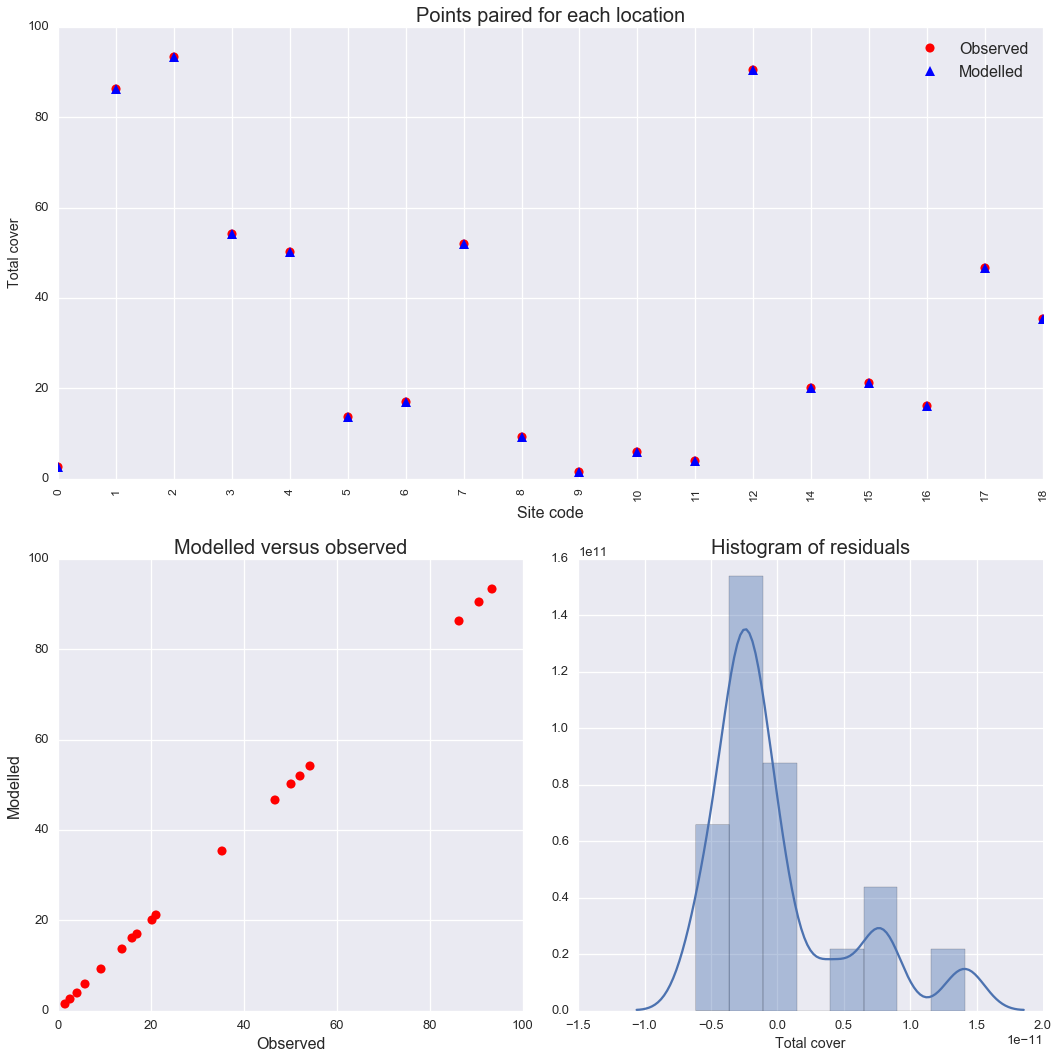

In [6]:
# Choose response
resp_var = 'Total cover'

# OLS
res = mlr(df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

#### 5.1.2. Elastic net

Mean r2 from 3-fold CV: -2.707

r2 (based on the calibration data i.e. meaningless!): 0.0

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 1882.42438272
Elastic net L1 ratio: 0.5



,effect,error,signif
Vann cond. (µS/cm),-0.0,0.546092,False
Vann temp. (C),-0.0,0.281226,False
Vann pH,0.0,0.000000,False
Vann redox (mV),-0.0,0.325261,False
PW cond. (µS/cm),0.0,0.438326,False
PW temp. (C),0.0,0.145276,False
PW pH,0.0,0.000000,False
PW redox (mV),-0.0,0.245314,False
NH4 (µg N/l),0.0,0.678022,False
SO4 (mg/l),0.0,0.000000,False


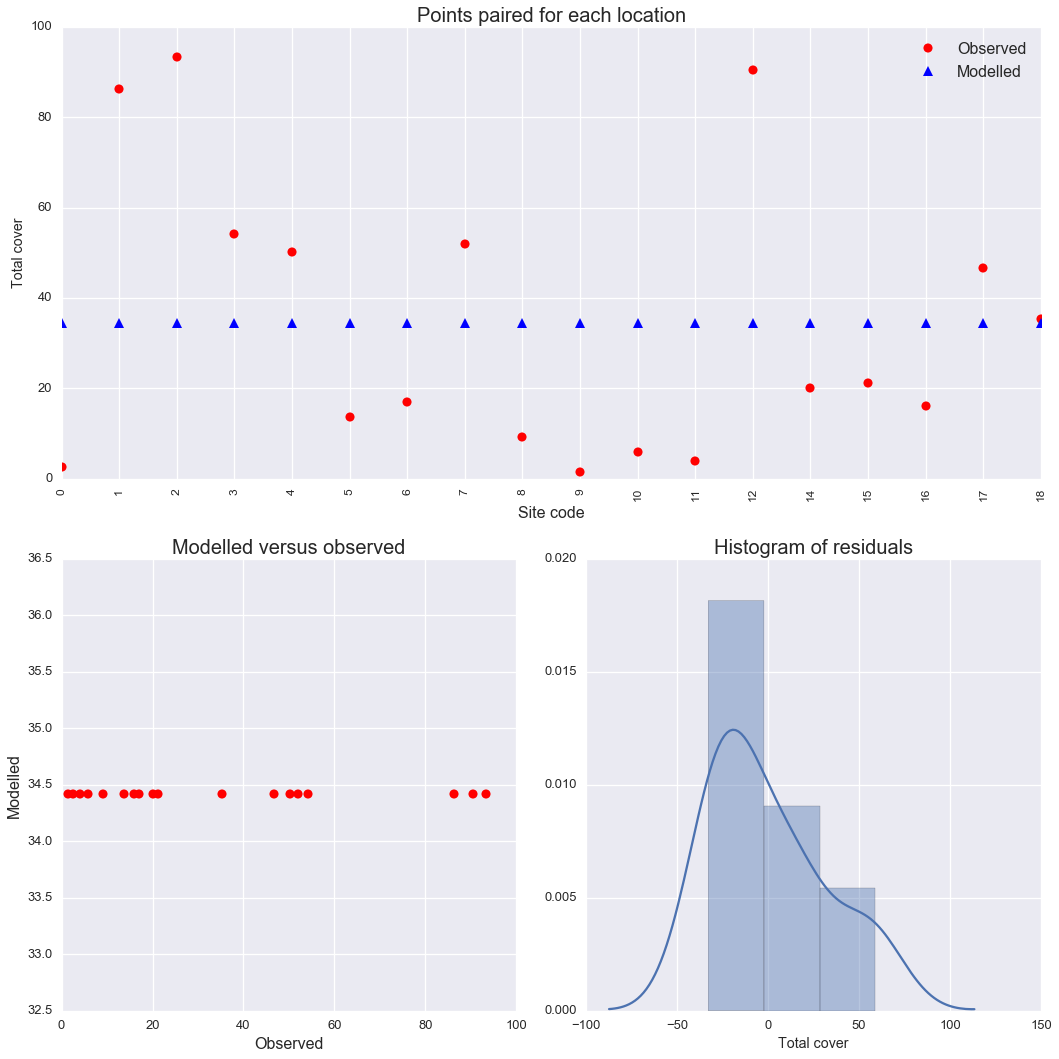

In [10]:
# Elastic net
res = mlr(df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res

### 5.2. Total volume

#### 5.2.1. OLS

Mean r2 from 3-fold CV: -565.062

r2 (based on the calibration data i.e. meaningless!): 1.0

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



,effect,error,signif
Vann cond. (µS/cm),-146.298544,389.949310,False
Vann temp. (C),-174.967892,665.514478,False
Vann pH,1573.585900,534.337332,True
Vann redox (mV),90.550416,83.917278,True
PW cond. (µS/cm),-57.839611,110.931684,False
PW temp. (C),1908.066658,690.983539,True
PW pH,3819.600938,563.603963,True
PW redox (mV),6.915761,70.507203,False
NH4 (µg N/l),681.848011,491.989395,True
SO4 (mg/l),483.029196,165.870283,True


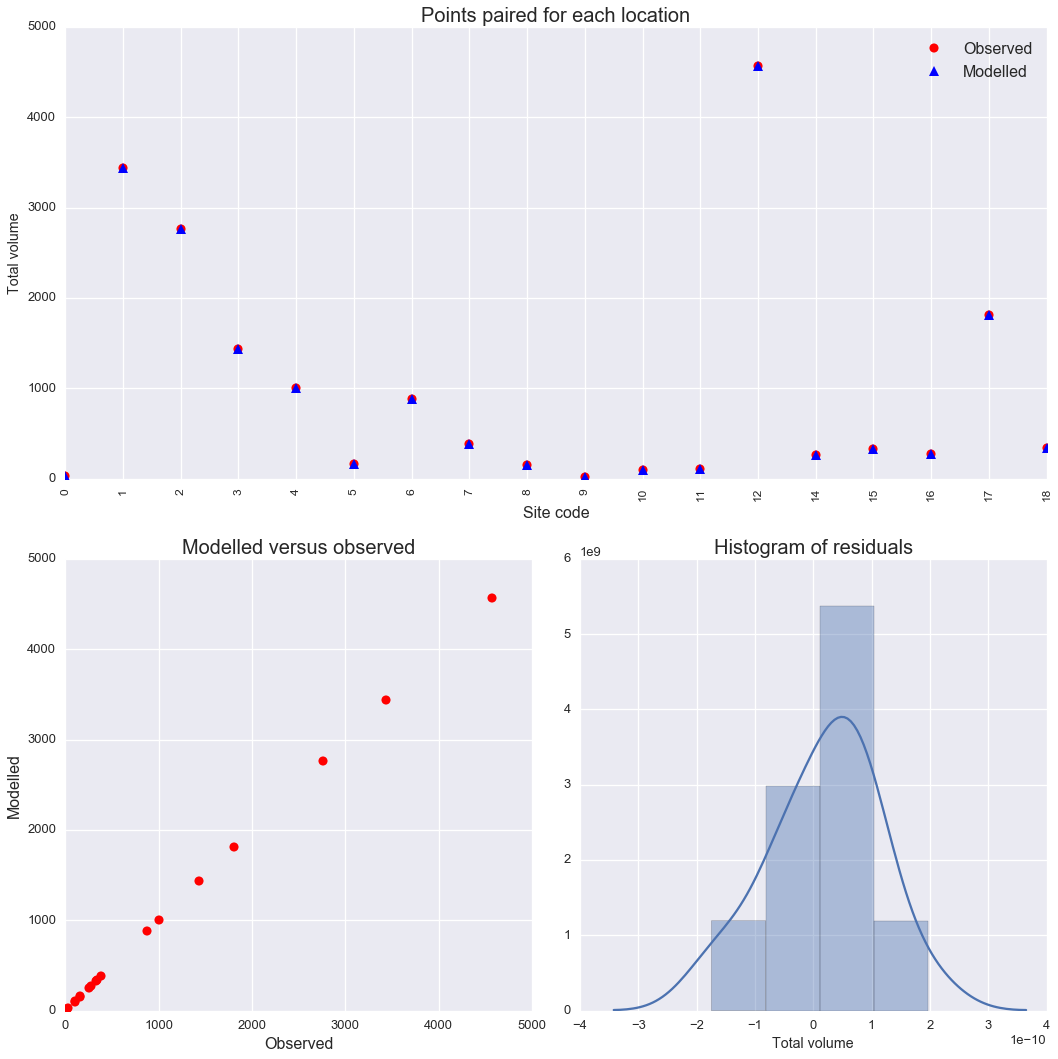

In [11]:
# Choose response
resp_var = 'Total volume'

# OLS
res = mlr(df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

#### 5.2.2. Elastic net

Mean r2 from 3-fold CV: -25.516

r2 (based on the calibration data i.e. meaningless!): 0.0240101616471

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 52822.3965441
Elastic net L1 ratio: 0.5



,effect,error,signif
Vann cond. (µS/cm),-0.000000,8.004911,False
Vann temp. (C),-0.000000,4.290161,False
Vann pH,0.000000,0.038095,False
Vann redox (mV),-0.000000,7.119265,False
PW cond. (µS/cm),0.000000,21.498193,False
PW temp. (C),-0.000000,2.834475,False
PW pH,-0.000000,0.191887,False
PW redox (mV),-0.000000,6.686216,False
NH4 (µg N/l),0.000000,14.754005,False
SO4 (mg/l),0.000000,0.000000,False


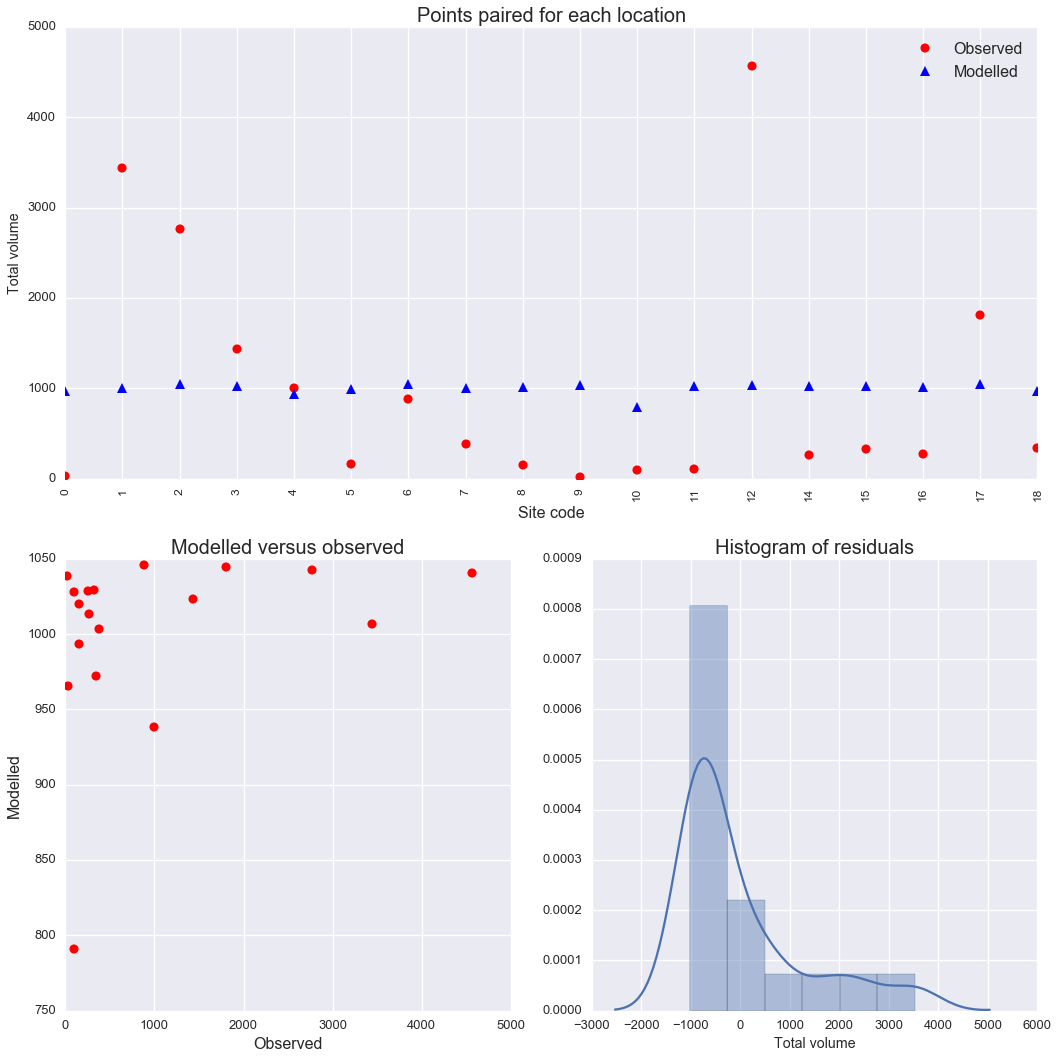

In [12]:
# Elastic net
res = mlr(df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res

## 6. Interpretation

These results are pretty-much as expected. The OLS output (sections 5.1.1 and 5.2.1) both fit the data perfectly, because the model has more parameters than data points. **This is a classic example of overfitting and the resulting parameter and significance estimates are meaningless**. Although the calibration $R^2$ for these models is equal to 1, the validation $R^2$ is large an negative, indicating that using a linear combination of all the explanatory variables is worse than just using a trivial model that always estimates the mean.

The elastic net results confirm that **the current chemistry dataset has essentially no explanatory power** when it comes to predicting either the percentage cover or the volume of krypsiv. The "best" model found by the elastic net algorithm in both cases is identical to the trivial model of just predicting the mean of the observations. As a result, the calibration $R^2$ is - by definition - equal to zero, and the validation $R^2$ is also slightly negative (but much less negative than the OLS result).

**The overall conclusion is that there are no clear relationships yet between chemical parameters and krypsiv coverage or volume**.